Mise en place

In [1]:
using Pkg
Pkg.activate("C:/Users/frank/Desktop/AOS212A/HW4/AOS212A_HW4") # Environment

  Activating project at `C:\Users\frank\Desktop\AOS212A\HW4\AOS212A_HW4`


In [4]:
# Packages
using Revise
using Profile
using ProgressMeter
using Plots
gr()
Plots.GRBackend()
using CurveFit, Printf
#using SparseArrays, LinearAlgebra, IterativeSolvers 

In [5]:
using HW4

## Problem Setup

Fully nonlinear, single-layer shallow water equation system in rotational form is given by

$$\begin{aligned}
\frac{\partial u}{\partial t}-q h v+\frac{\partial B}{\partial x} &=0 \\
\frac{\partial v}{\partial t}+q h u+\frac{\partial B}{\partial y} &=0 \\
\frac{\partial h}{\partial t}+\frac{\partial(h u)}{\partial x}+\frac{\partial(h v)}{\partial y} &=0,
\end{aligned}$$

where $h$ is the total water column height (can later be replaced by a bottom topography $h+z_b(x,y)$); $q=(\zeta+f) / h$ is the barotropic potential vorticity; $\zeta=(\partial v / \partial x-\partial u / \partial y)$ is the vertical vorticity; and $B=g h+\left(u^{2}+v^{2}\right) / 2$ is the total energy. This system conserves total mass, energy, and potential enstrophy (i.e. $(1/2)q^2$).

## Schemes

Spatial discretization: MAC grid (Arakawa C staggered grid)

Time discretization: Euler-Forward

## Test case

For a test case, we will study the geostrophic adjustment problem on the domain $0 \leq x \leq Lx$ and $0 \leq y \leq Ly$. For initial condition we will prescribe a quiescent state (with $u(t = 0) = v(t = 0) = 0$ everywhere) and a Gaussian unbalanced height given by

$$h(x, y, t=0)=H\left[1+\frac{1}{2} \exp \left(-\frac{\left(x-x_{0}\right)^{2}+\left(y-y_{0}\right)^{2}}{a^{2}}\right)\right],$$

where $a$ is the radius of the vortex at $(x_0,y_0)$.

### Parameters

In [6]:
g = 10^(-3) # m/s^2
H = 1000 # m
f = 10^(-4) # s^-1
c = sqrt(g*H)
λR = c/f
Lx = Ly = 10*λR
x0 = 5*λR
y0 = 5*λR
a = 1.25*λR;

In [7]:
Δx = Δy = 1000
Nx = (Lx-0)/Δx+1
Ny = (Ly-0)/Δy+1
x = 0:Δx:Lx
y = 0:Δy:Ly;

### Grid

In [8]:
# x components
ux = Δx/2:Δx:(Lx+Δx/2)
vx = 0:Δx:Lx
hx = 0:Δx:Lx
qx = Δx/2:Δx:(Lx+Δx/2)
# y components
uy = 0:Δy:Ly
vy = Δy/2:Δy:(Ly+Δy/2);
hy = 0:Δy:Ly
qy = Δy/2:Δy:(Ly+Δy/2)

# index
i = Int.(2:Nx-1)
j = Int.(2:Ny-1);

### Time

In [9]:
v_x = 60
Δt = 0.5*Δx/v_x # CFL condition
nsteps = 10000 # time steps
Co = 2*v_x*Δt/Δx # courant number

1.0000000000000002

### Initial Condition

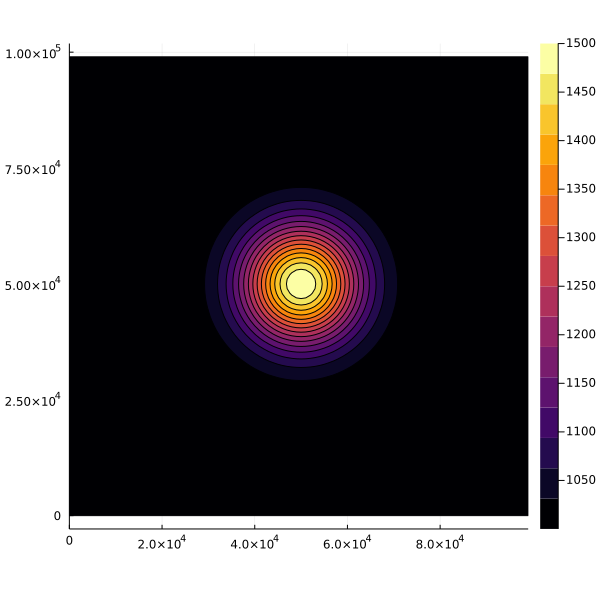

In [10]:
h0 = [H*(1+0.5*exp(-((x-x0)^2+(y-y0)^2)/a^2)) for x in 0:Δx:Lx, y in 0:Δy:Ly] 
contour(x,y,h0, fill = true, aspect_ratio=1.0, size=(600,600))

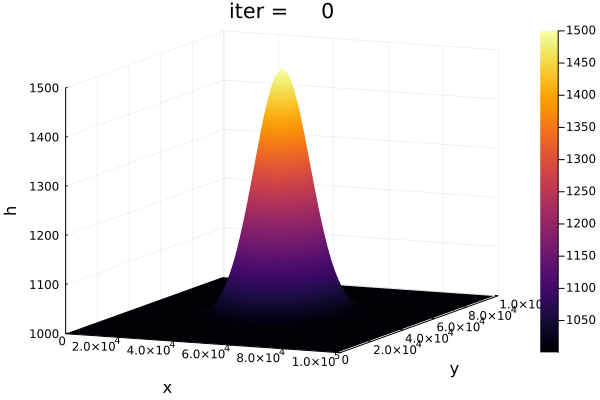

In [11]:
plot(x, y, h0, st = :surface, xlabel = "x", ylabel = "y", zlabel = "h", 
    xlim = (0, 10^5), ylim = (0, 10^5), zlim = (1000,1500),
    title = @sprintf("iter = %5i",0))

In [12]:
u = zeros(length(ux),length(uy))
v = zeros(length(ux),length(uy))
h = h0;

### Boundary Condition

In [13]:
# BCtype = "no-slip"
 BCtype = "periodic"

"periodic"

In [14]:
ax1 = h.*ones(length(hx),length(hy))
q = f./h.*ones(length(qx),length(qy))
U = u
V = v
B = g.*h
axV = zeros(length(vx),length(vy)) 
ayU = zeros(length(ux),length(uy))
#ayax1 = zeros(length(qx),length(qy));

In [15]:
# operator functions
# δx(p)
dxfcn(p::AbstractMatrix) = (1/Δx).*(p[i.+1,j] .- p[i.-1,j])
# δy(p)
dyfcn(p::AbstractMatrix) = (1/Δy).*(p[i,j.+1] .- p[i,j.-1]) 
# ̅pˣ
axfcn(p::AbstractMatrix) = 0.5.*(p[i.+1,j] .+ p[i.-1,j]) 
# ̅pʸ
ayfcn(p::AbstractMatrix) = 0.5.*(p[i,j.+1] .+ p[i,j.-1]); 

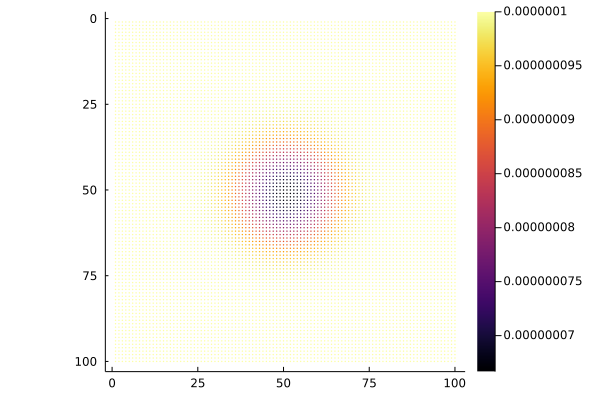

In [16]:
spy(q)

### Time Engine

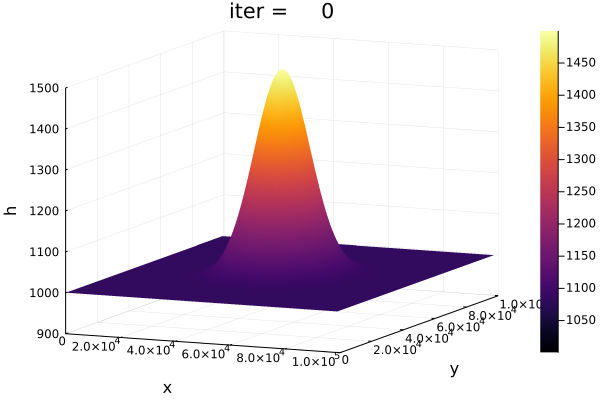

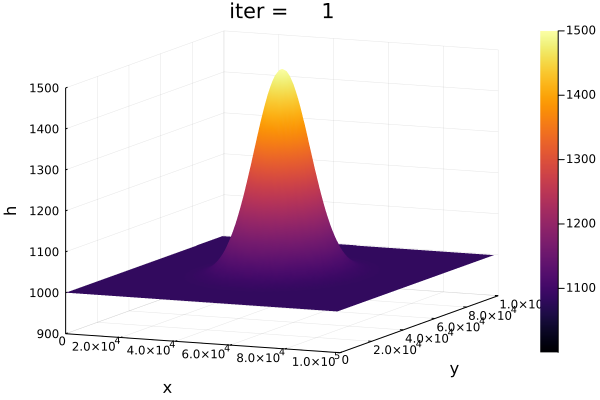

Computing... 33%|██████████████                         |  ETA: 0:00:07

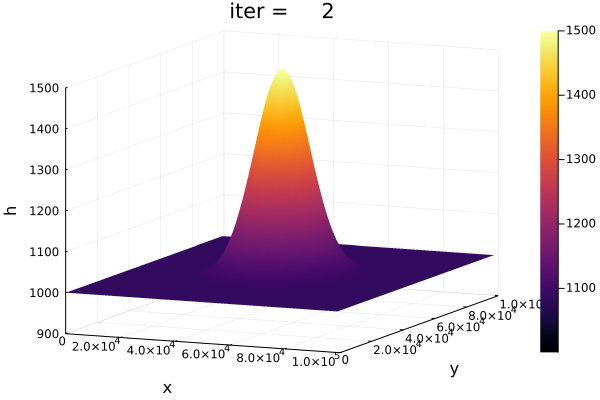

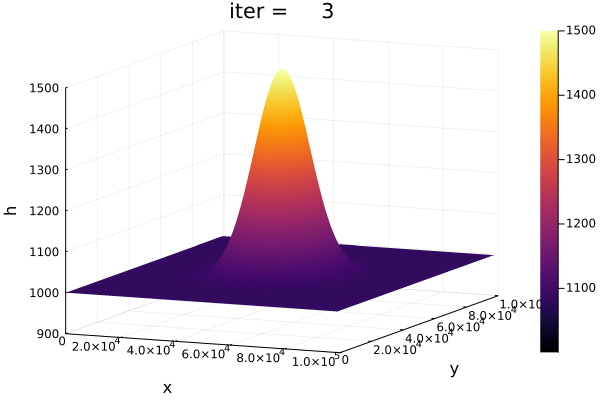

Computing... 67%|███████████████████████████            |  ETA: 0:00:03

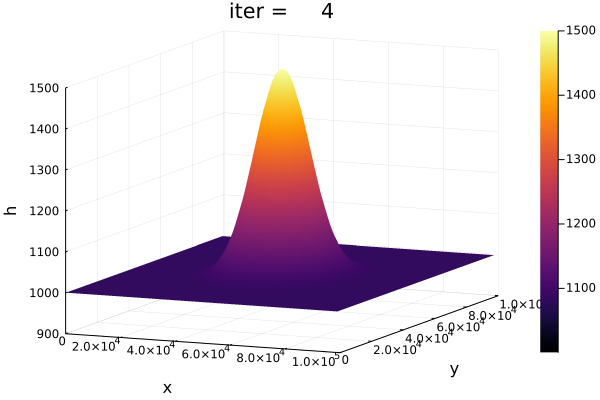

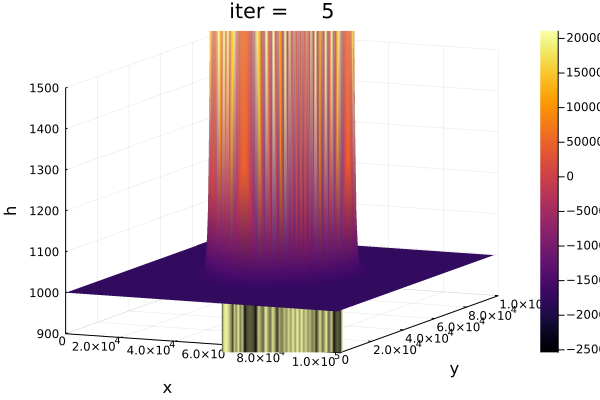

Computing...100%|███████████████████████████████████████| Time: 0:00:06


In [17]:
# cache
ticache = []; Ecache = []; Zcache = []; hcache = []; qcache = []; ζcache = []; ucache = []; vcache = [];

# store
nstore = 1
nstore2 = 1
#nstore = 500
#nstore2 = 1000

# Euler forward
# March!
@showprogress 1 "Computing..."  for ti in 0:5
    
    #update previous matrices
        u_n = deepcopy(u)
        v_n = deepcopy(v)
        h_n = deepcopy(h)
    
    # fields
        # U = u*h; interpolate h to u positions
            U[i,j] = axfcn(h) .* u[i,j]
            U = HW4.applyBC(U,BCtype)
        # V = v*h; interpolate h to v positions
            V[i,j] = ayfcn(h) .* v[i,j] 
            V = HW4.applyBC(V,BCtype)
        # B = gh + 1/2(u^2 + v^2); u and v are interpolated to h positions
            B[i,j] = g.*h[i,j] .+ 0.5.*(axfcn(u.^2) .+ ayfcn(v.^2))
            B = HW4.applyBC(B,BCtype)
        # q = (zeta + f)/h; u, v, and h are interpolated to q positions
            ax1[i,j] = axfcn(h)  # first interpolate h to u positions
            ax1 = HW4.applyBC(ax1,BCtype)
    
            q[i,j] = 1 ./ ayfcn(ax1) .* (dxfcn(v) .- dyfcn(u) .+ f) 
            ζ = dxfcn(v) .- dyfcn(u)
            q = HW4.applyBC(q,BCtype)

    # conserving enstrophy
        # u, to u positions
            axV[i,j] = axfcn(V) # first interpolate V to q positions
            axV = HW4.applyBC(axV,BCtype)
            u[i,j] = u_n[i,j] .+ Δt.*(ayfcn(q) .* ayfcn(axV) .- dxfcn(B))
            u = HW4.applyBC(u,BCtype)
        # v, to v positions
            ayU[i,j] = ayfcn(U) # first interpolate U to q positions
            ayU = HW4.applyBC(ayU,BCtype)
    
            v[i,j] = v_n[i,j] .+ Δt.*(- axfcn(q) .* axfcn(ayU) .- dyfcn(B))
            v = HW4.applyBC(v,BCtype)
        # h, to h positions
            h[i,j] = h_n[i,j] .+ Δt.*(- dxfcn(U) .- dyfcn(V))
            h = HW4.applyBC(h,BCtype)

    # conservation quantities
        # energy
        E = sum(B)
        # enstrophy
        Z = 0.5.*sum(q[i,j].^2 .* ayfcn(ax1)) 

    # store every 'nstore' time steps
    if mod(ti,nstore) == 0
        push!(ticache,deepcopy(ti)) # index
        push!(Ecache, deepcopy(E))  # energy
        push!(Zcache, deepcopy(Z))  # enstrophy
        push!(hcache, deepcopy(h))  # 
        push!(qcache, deepcopy(q))
        push!(ζcache, deepcopy(ζ))
        push!(ucache, deepcopy(u))
        push!(vcache, deepcopy(v))
    end  
    
     # plot
    if mod(ti,nstore2) == 0
        display(plot(hx,hy,h, st = :surface, xlabel = "x", ylabel = "y", zlabel = "h", 
            title = @sprintf("iter = %5i",ti), xlim = (0, 10^5), ylim = (0, 10^5), zlim = (900,1500)))
        # xlim = (0, 10^5), ylim = (0, 10^5), zlim = (1000,1500)
             # axis([0 Lx 0 Ly 800 1500])
             #view(60,35)
             #cbar = colorbar;
             #caxis([900 1400])             
             #drawnow;
    end
end

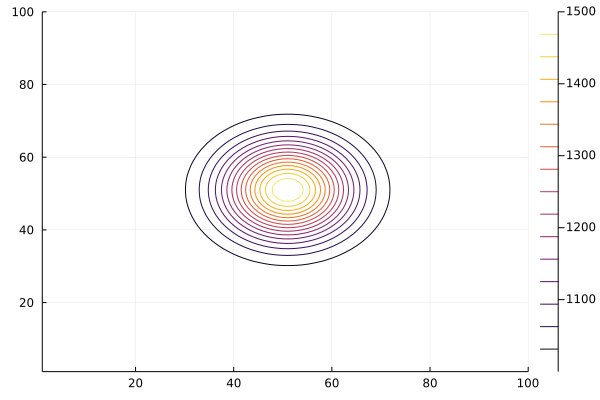

In [201]:
contour(hcache[2])

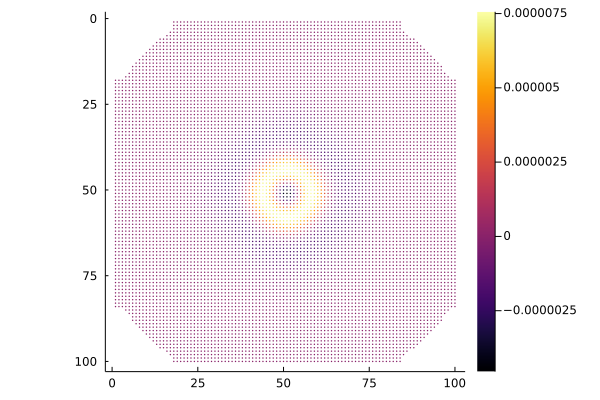

In [187]:
spy(hcache[1]-hcache[2])

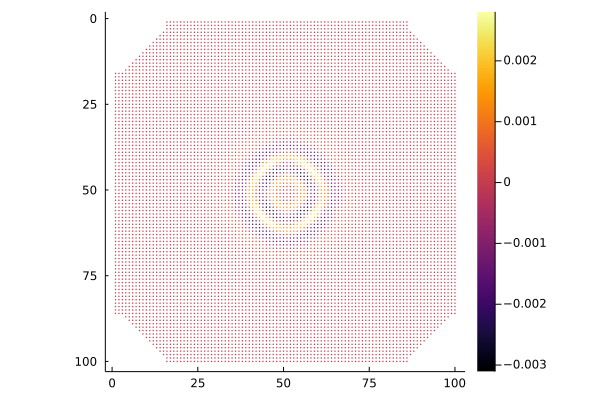

In [102]:
spy(hcache[4]-hcache[3])

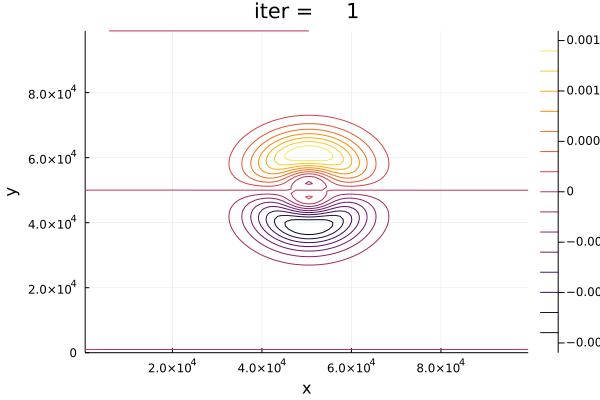

In [64]:
display(plot(ux,uy,u, xlabel = "x", ylabel = "y", zlabel = "u", title = @sprintf("iter = %5i",1)))

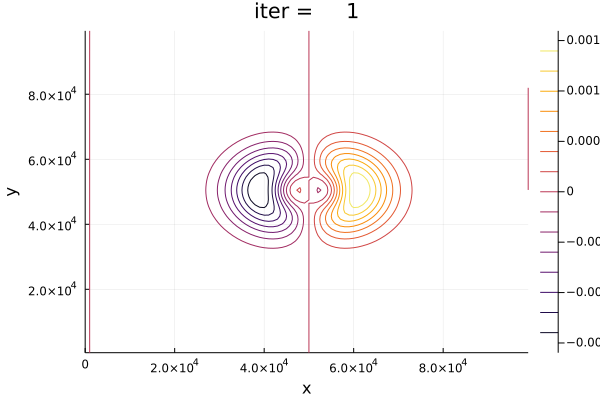

In [66]:
display(plot(vx,vy,v, xlabel = "x", ylabel = "y", zlabel = "v", title = @sprintf("iter = %5i",1)))

In [44]:
Zcache

11-element Vector{Any}:
   4.702258928909453e-8
   4.7022590009686846e-8
   4.7023550386989243e-8
   4.704086940135001e-8
   1.422052358894844e-7
   0.4163129784485141
   1.7729424594696096e16
   1.8510369011793707e85
 NaN
 NaN
 NaN